In [34]:
import gurobipy as gp
from gurobipy import *
import numpy as np
from numpy import loadtxt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
import random
random.seed(10)
import time
from heapq import nsmallest

from scipy.stats import cauchy

In [35]:
from ipynb.fs.full.Heuristics import *

In [36]:
def beta_generate(mean, var, s):
    alpha = mean*((mean*(1-mean))/var - 1)
    beta = (1-mean)*((mean*(1-mean))/var - 1)
    value = np.random.beta(alpha, beta, size = s)   
    return value
    

# Load data

In [6]:
df_csv = pd.read_csv(' ') #Load our data set

def lat_lon_distmatrix(df_csv):
    dist = np.zeros((length,length+1)) #Plus emergency 
    df = pd. DataFrame(df_csv[['lat','lon']])
    records = df.to_records(index=False)
    result = list(records)
    for i in range(len(result)):
        for j in range(len(result)):
            dist[i,j] = geopy.distance.distance(result[i], result[j]).km*0.621371
    return dist
length = df_csv.shape[0]
c_ij = lat_lon_distmatrix(df_csv)*(10**(-5))
c_ij[:,length] = c_ij[:,length]+0.1  #Emergency cost


V_1 = [i for i in range(0, length)] # Customer
V_2 = [i for i in range(0, length+1)] # Facility + Emergency
R = [i for i in range(0, 3)] #Backup leve
T = [i for i in range(1, 5)] #Time 4 period  (1,5)
TE = [i for i in range(0, 5)] # include period 0 (0,5)

###### Convex Hull ########

Hull_set = [0, 2, 4, 7, 21, 29,13, 28, 14]
set_init = set( [0, 2, 4, 7, 21, 29])
V_2 = list(set_init.union(Hull_set)) +[length] # 49 Or 88

###########################


d_i = list(df_csv['demand']*10000)

f_j = list(df_csv['fixed cost']) + [0]

#A = [(i, j, r, t) for i in V_1 for j in V_2 for r in R for t in T]
A = [(i, j, r) for i in V_1 for j in V_2 for r in R ]

J = V_2[-1]
E = [(i, j) for i in V_1 for j in V_2 ]

#A_1 = [(i, j, r, t) for i in V_1 for j in V_2[:-1] for r in R[:-1] for t in T]
A_1 = [(i, j, r) for i in V_1 for j in V_2[:-1] for r in R[:-1]]

o = 3000/1
c = 3000/1
jt = [(j, t) for j in V_2 for t in T]

## Multi period information #####################
q_jt = np.zeros((len(V_1)+1,4))
info = [1,2,4,8]
for i in range(0,4):
    q_jt[:,i] = list(df_csv['prob_fail'] *(info[i])) + [0] #Prob_fail + Emergency facility
    # (i+1)*0.25


d_it = np.zeros((len(d_i),4))
rho = 1 #0, 0.5, 1 
for i in range(0,4):
    d_it[:,i] = np.array(d_i)*((q_jt[:-1,i]*rho)+1) #Prob_fail + Emergency facility

    
for i in V_1:
    #if i not in idx_fix:      
    f_j[i] =  f_j[i]/10
##################################################


#info = [0.1, 0.5, 1.0, 2.5]   Result diff 2 %
#info = [0.1, 0.2, 0.8, 3.0]   Result diff 3.4 %

In [67]:
# Interdict model , Add protected cost
'''for i in [2, 4, 7, 29]:
    f_j[i] = f_j[i]+10000'''

'for i in [2, 4, 7, 29]:\n    f_j[i] = f_j[i]+10000'

# Cost function

In [68]:
# Reslixstion RAW generate sample
sample = 1000


for VMR in [0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]:
    #######################################################################################################################
    RAW = {}
    for t in range(4):
        df_q = pd.read_csv('Data/q_sensitivity/q_{}_{}.csv'.format(VMR,t)) #download q_sensitivity data
        df_q = df_q.drop(df_q.columns[0], axis = 1)
        arr_q = np.array(df_q)
        for i in range(sample):
            RAW["{}_{}".format(t,i)] = arr_q[i]
    # Keep realization to Q dict by sample
    Q = {}
    for s in range(sample):
        Q[s] = np.stack((RAW["0_{}".format(s)],RAW["1_{}".format(s)],RAW["2_{}".format(s)],RAW["3_{}".format(s)])).T

    #######################################################################################################################
    OUTPUT = {}
    OUTPUT[-1] = [0, 2, 4, 7, 21, 29]
    OUTPUT[0] = [0, 2, 4, 13, 21, 29]
    OUTPUT[1] = [0, 2, 4, 13, 21, 28, 29]
    OUTPUT[2] = [0, 2, 4, 13, 21, 28, 29]
    OUTPUT[3] = [0, 2, 4, 13, 14, 21, 28]
    COST = {}

    open_cost = 3000

    for s in range(sample):
        real_qjt = Q[s]
        COST[s] = 0
        for t in range(4):
            #Previous X
            idx_x = OUTPUT[t-1]
            X = np.zeros(len(V_1))
            for i in idx_x:
                X[i] = 1
            X_init = X.copy()
            #Current X
            idx_bx = OUTPUT[t]
            BX = np.zeros(len(V_1))
            for i in idx_bx:
                BX[i] = 1


            best_x = BX.copy()
            # Assign y
            y, w = nearest_YSol(real_qjt, c_ij, best_x, V_1, V_2, R, t)
            # Calculate Cost

            COST[s] = COST[s] + cal_Fixcost(best_x, f_j, V_2) + cal_Valcost(real_qjt, y, c_ij, list(d_it[:,t]), A, V_1, V_2, R, t) + cal_Opencost(best_x, X_init, open_cost)


    result = COST.items()
    # Convert object to a list
    data = list(result)
    arr_data = np.array(data)

    #SAVE
    df_cost = pd.DataFrame(arr_data)
    df_cost[1].to_csv('cost_{}.csv'.format(VMR)) #save the result
    
  
    

# For IM model

In [64]:
# Reslixstion RAW generate sample
sample = 1000


for VMR in [0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]:
    #######################################################################################################################
    RAW = {}
    for t in range(4):
        df_q = pd.read_csv('C:/Users/USER/OneDrive/Work TBSI/Graduate/Paper/q_sensitivity/q_{}_{}.csv'.format(VMR,t))
        df_q = df_q.drop(df_q.columns[0], axis = 1)
        arr_q = np.array(df_q)
        ########################## IM Fortification
        for i in [2, 4, 7, 29]:  #protected node
            arr_q[:,i] = 0
        ##########################
        for i in range(sample):
            RAW["{}_{}".format(t,i)] = arr_q[i]
    # Keep realization to Q dict by sample
    Q = {}
    for s in range(sample):
        Q[s] = np.stack((RAW["0_{}".format(s)],RAW["1_{}".format(s)],RAW["2_{}".format(s)],RAW["3_{}".format(s)])).T
    
    #######################################################################################################################
    OUTPUT = {}
    OUTPUT[-1] = [0, 2, 4, 7, 21, 29]
    OUTPUT[0] = [0, 2, 4, 7, 21, 29]
    OUTPUT[1] = [0, 2, 4, 7, 21, 29]
    OUTPUT[2] = [0, 2, 4, 7, 21, 29]
    OUTPUT[3] = [0, 2, 4, 7, 21, 29]
    COST = {}
    open_cost = 3000

    for s in range(sample):
        real_qjt = Q[s]
        COST[s] = 0
        for t in range(4):
            #Previous X
            idx_x = OUTPUT[t-1]
            X = np.zeros(len(V_1))
            for i in idx_x:
                X[i] = 1
            X_init = X.copy()
            #Current X
            idx_bx = OUTPUT[t]
            BX = np.zeros(len(V_1))
            for i in idx_bx:
                BX[i] = 1


            best_x = BX.copy()
            # Assign y
            y, w = nearest_YSol(real_qjt, c_ij, best_x, V_1, V_2, R, t)
            # Calculate Cost

            COST[s] = COST[s] + cal_Fixcost(best_x, f_j, V_2) + cal_Valcost(real_qjt, y, c_ij, list(d_it[:,t]), A, V_1, V_2, R, t) + cal_Opencost(best_x, X_init, open_cost)


    result = COST.items()
    # Convert object to a list
    data = list(result)
    arr_data = np.array(data)

    #SAVE
    df_cost = pd.DataFrame(arr_data)
    df_cost[1].to_csv('cost_IM_{}.csv'.format(VMR)) #save the result
    
   
    

In [83]:
OUTPUT = {}
OUTPUT[-1] = [0, 2, 4, 7, 21, 29]
OUTPUT[0] = [0, 2, 4, 13, 21, 29]
OUTPUT[1] = [0, 2, 4, 13, 21, 28, 29]
OUTPUT[2] = [0, 2, 4, 13, 21, 28, 29]
OUTPUT[3] = [0, 2, 4, 13, 14, 21, 28]
COST = {}
open_cost = 3000

s=1
real_qjt = q_jt
COST[s] = 0

for t in range(4):
    #Previous X
    idx_x = OUTPUT[t-1]
    X = np.zeros(len(V_1))
    for i in idx_x:
        X[i] = 1
    X_init = X.copy()
    #Current X
    idx_bx = OUTPUT[t]
    BX = np.zeros(len(V_1))
    for i in idx_bx:
        BX[i] = 1


    best_x = BX.copy()
    # Assign y
    y, w = nearest_YSol(real_qjt, c_ij, best_x, V_1, V_2, R, t)
    # Calculate Cost

    COST[s] = COST[s] + cal_Fixcost(best_x, f_j, V_2) + cal_Valcost(real_qjt, y, c_ij, list(d_it[:,t]), A, V_1, V_2, R, t) + cal_Opencost(best_x, X_init, open_cost)

result = COST.items()
# Convert object to a list
data = list(result)
arr_data = np.array(data)

# Graph multi

In [38]:
#Load
list_df = []
for vmr in [0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]:
    df_csv = pd.read_csv('C:/Users/USER/OneDrive/Work TBSI/Graduate/Paper/Result_sensitivity/cost_{}.csv'.format(vmr))
    arr = list(np.array(df_csv)[:,1])
    list_df.append(arr)
arr_df = np.array(list_df).T

#Load
list_df_WC = []
for vmr in [0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]:
    df_csv = pd.read_csv('C:/Users/USER/OneDrive/Work TBSI/Graduate/Paper/Result_sensitivity/cost_IM_{}.csv'.format(vmr))
    arr = list(np.array(df_csv)[:,1])
    list_df_WC.append(arr)
arr_df_WC = np.array(list_df_WC).T

Text(0, 0.5, 'Cost')

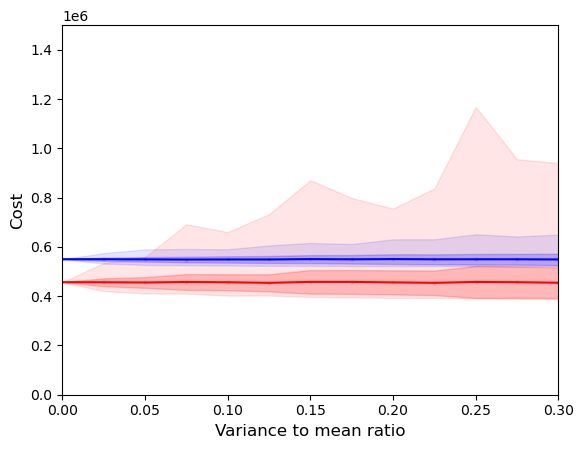

In [6]:

y = np.mean(arr_df, axis =0)
y = np.concatenate(([456751.18] ,y), axis = 0)
x = np.array([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3])
y_max =  np.max(arr_df , axis = 0)
y_max = np.concatenate(([456751.18] ,y_max), axis = 0)
y_min = np.min(arr_df , axis = 0)
y_min = np.concatenate(([456751.18] ,y_min), axis = 0)
                       
y_wc = np.mean(arr_df_WC, axis =0)
y_wc= np.concatenate(([550000] ,y_wc), axis = 0)
x_wc = np.array([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3])
y_max_wc =  np.max(arr_df_WC , axis = 0)
y_max_wc = np.concatenate( ([550000] ,y_max_wc), axis = 0)

y_min_wc = np.min(arr_df_WC , axis = 0)
y_min_wc = np.concatenate(([550000] ,y_min_wc), axis = 0)

# fit a linear curve an estimate its y-values and their error.


y_err = np.std(arr_df,axis = 0)
y_err = np.concatenate( ([0] ,y_err), axis = 0)

y_err_wc = np.std(arr_df_WC,axis = 0)
y_err_wc = np.concatenate( ([0] ,y_err_wc), axis = 0)

fig, ax = plt.subplots()

ax.plot(x, y, '-', alpha = 1, c = 'r')
ax.fill_between(x, y - y_err, y + y_err, alpha=0.2  , color='r')
ax.fill_between(x, y_max, y_min, alpha=0.1 , color='r')

ax.plot(x_wc, y_wc, '-', alpha = 1, c = 'b')
ax.fill_between(x_wc, y_wc - y_err_wc, y_wc + y_err_wc, alpha=0.2  , color='b')
ax.fill_between(x_wc, y_max_wc, y_min_wc, alpha=0.1 , color='b')

ax.plot(x, y, 'o', color='r',  markersize=2 , alpha = 0.1 )
ax.plot(x_wc, y_wc, 'o', color='b',  markersize=2 , alpha = 0.1 )

plt.ylim((0,1500000))
plt.xlim([0, 0.3])
#ax.get_yaxis().set_visible(False)
#plt.grid(axis = 'both',color='white', linestyle='-', linewidth=0.6)
#ax.set_facecolor("whitesmoke" )

#fig.suptitle('Sensitivity Analysis', fontsize=12)
plt.xlabel('Variance to mean ratio', fontsize=12)
plt.ylabel('Cost', fontsize=12)

Text(0, 0.5, 'Cost')

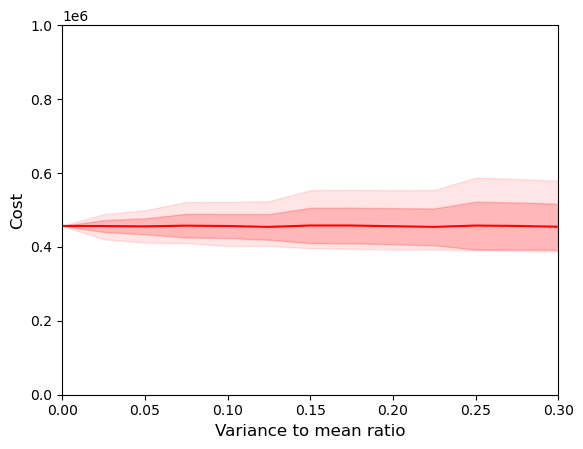

In [39]:

y = np.mean(arr_df, axis =0)
y = np.concatenate(([456751.18] ,y), axis = 0)
x = np.array([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3])

y_max =  np.max(arr_df , axis = 0)
y_max = np.concatenate(([456751.18] ,y_max), axis = 0)
y_min = np.min(arr_df , axis = 0)
y_min = np.concatenate(([456751.18] ,y_min), axis = 0)
                       


y_err = np.std(arr_df,axis = 0)
y_err = np.concatenate( ([0] ,y_err), axis = 0)

fig, ax = plt.subplots()

ax.plot(x, y, '-', alpha = 1, c = 'r' )
ax.fill_between(x, y - y_err, y + y_err, alpha=0.2  , color='r')
ax.fill_between(x, y + 2*y_err, y_min, alpha=0.1 , color='r')



#ax.plot(x, y, 'o', color='r',  markersize=2 , alpha = 0.1 )


plt.ylim((0,1000000))
plt.xlim([0, 0.3])
#ax.get_yaxis().set_visible(False)
#plt.grid(axis = 'both',color='white', linestyle='-', linewidth=0.6)
#ax.set_facecolor("whitesmoke" )

#fig.suptitle('Sensitivity Analysis', fontsize=16)
plt.xlabel('Variance to mean ratio', fontsize=12)
plt.ylabel('Cost', fontsize=12)

# Graph WC single graph

Text(0, 0.5, 'Cost')

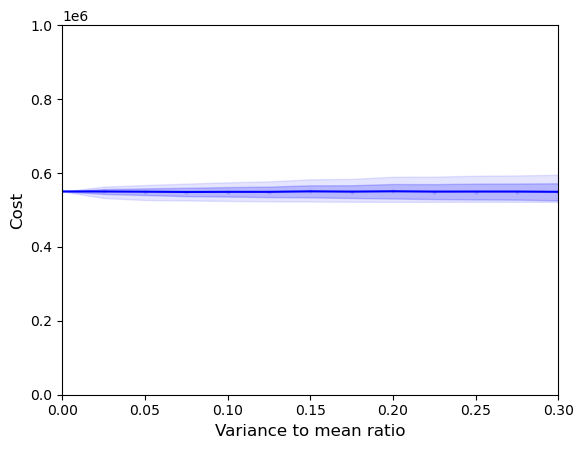

In [40]:

y_wc = np.mean(arr_df_WC, axis =0)
y_wc= np.concatenate(([550000] ,y_wc), axis = 0)
x_wc = np.array([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3])
y_max_wc =  np.max(arr_df_WC , axis = 0)
y_max_wc = np.concatenate( ([550000] ,y_max_wc), axis = 0)

y_min_wc = np.min(arr_df_WC , axis = 0)
y_min_wc = np.concatenate(([550000] ,y_min_wc), axis = 0)

# fit a linear curve an estimate its y-values and their error.


y_err_wc = np.std(arr_df_WC,axis = 0)
y_err_wc = np.concatenate( ([0] ,y_err_wc), axis = 0)

fig, ax = plt.subplots()


ax.plot(x_wc, y_wc, '-', alpha = 1, c = 'b')
ax.fill_between(x_wc, y_wc - y_err_wc, y_wc + y_err_wc, alpha=0.2  , color='b')
ax.fill_between(x_wc, y_wc + 2*y_err_wc, y_min_wc, alpha=0.1 , color='b')


ax.plot(x_wc, y_wc, 'o', color='b',  markersize=2 , alpha = 0.1 )

plt.ylim((0,1000000))
plt.xlim([0, 0.3])
#ax.get_yaxis().set_visible(False)
#plt.grid(axis = 'both',color='white', linestyle='-', linewidth=0.6)
#ax.set_facecolor("whitesmoke" )

#fig.suptitle('Sensitivity Analysis', fontsize=12)
plt.xlabel('Variance to mean ratio', fontsize=12)
plt.ylabel('Cost', fontsize=12)